# Data 245 - Machine Learning Project 

# Internet Downtime Prediction Analysis using ML Techniques

### Presented By: Group 6 (Bhavik Patel, Poojan Gagrani, Kashish Thakur, Yuti Khamker)

## 1. Importing libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mp
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.utils import resample, shuffle
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

## 2. Reading file

In [5]:
df = pd.read_csv('Outage_Data.csv')

In [6]:
df = df.sample(n=100000, random_state=42).reset_index(drop=True)

## 3. Data understanding

### Original feature description from data source, Ref: https://wiki.mozilla.org/Mozilla_Network_Outages_Data_Project

`country`: the Country code of the client.

`city`: the City name (only for cities with a population >= 15000, 'unknown' otherwise).

`datetime`: the date and the time (truncated to hour) the data was submitted by the client.

`proportion_undefined`: the proportion of users who failed to send telemetry for a reason that was not listed in the other cases.

`proportion_timeout`: the proportion of users that had their connection timeout while uploading telemetry (after 90s, in Firefox Desktop).

`proportion_abort`: the proportion of users that had their connection terminated by the client (for example, terminating open connections before shutting down).

`proportion_unreachable`: the proportion of users that failed to upload telemetry because the server was not reachable (e.g. because the host was not reachable, proxy problems or OS waking up after a suspension).

`proportion_terminated`: the proportion of users that had their connection terminated internally by the networking code.

`proportion_channel_open`: the proportion of users for which the upload request was terminated immediately, by the client, because of a Necko internal error.

`avg_dns_success_time`: the average time it takes for a successful DNS resolution, in milliseconds.

`missing_dns_success`: counts how many sessions did not report the `DNS_LOOKUP_TIME` histogram.

`avg_dns_failure_time`: the average time it takes for an unsuccessful DNS resolution, in milliseconds.

`missing_dns_failure`: counts how many sessions did not report the `DNS_FAILED_LOOKUP_TIME` histogram.

`count_dns_failure`: the average count of unsuccessful DNS resolutions reported.

`ssl_error_prop`: the proportion of users that reported an error through the `SSL_CERT_VERIFICATION_ERRORS` histogram.

`avg_tls_handshake_time`: the average time after the TCP SYN to ready for HTTP, in milliseconds.

### Defining dataset

In [7]:
df.head()

,country,city,datetime,proportion_undefined,proportion_timeout,proportion_abort,proportion_unreachable,proportion_terminated,proportion_channel_open,avg_dns_success_time,missing_dns_success,avg_dns_failure_time,missing_dns_failure,count_dns_failure,ssl_error_prop,avg_tls_handshake_time
0,FR,Romans-sur-Isère,2023-02-20 09:00:00+00:00,0.000000,0.003656,0.003656,0.124314,0.076782,0.000000,31.169516,0.000000,14.564475,0.0,46.423855,0.040471,91.977353
1,US,Dublin,2023-08-28 04:00:00+00:00,0.000000,0.007201,0.000000,0.058506,0.009001,0.000000,30.415173,0.000000,19.549192,0.0,352.765659,0.126770,75.952639
2,IN,Chennai,2023-05-14 19:00:00+00:00,0.000000,0.005670,0.000000,0.093127,0.017526,0.000344,23.443062,0.000078,9.709975,0.0,823.013169,0.084169,47.767434
3,CH,Lugano,2023-05-02 10:00:00+00:00,0.000000,0.004975,0.002488,0.194030,0.059701,0.000000,17.499015,0.000000,9.997338,0.0,77.104019,0.052542,70.791734
4,US,San Jose,2023-04-14 17:00:00+00:00,0.000937,0.026546,0.001249,0.387570,0.053092,0.000000,37.155666,0.000000,7.158672,0.0,8786.161484,0.082357,90.034052


**Description**

Showing first 5 values of the dataframe.

In [8]:
df.tail()

,country,city,datetime,proportion_undefined,proportion_timeout,proportion_abort,proportion_unreachable,proportion_terminated,proportion_channel_open,avg_dns_success_time,missing_dns_success,avg_dns_failure_time,missing_dns_failure,count_dns_failure,ssl_error_prop,avg_tls_handshake_time
99995,US,Billings,2023-02-09 17:00:00+00:00,0.0,0.005000,0.000000,0.295000,0.055000,0.0,36.315391,0.0,12.338339,0.0,78.712909,0.073939,110.182113
99996,US,Evansville,2023-02-01 01:00:00+00:00,0.0,0.015444,0.000000,0.150579,0.050193,0.0,46.465138,0.0,24.801613,0.0,61.927900,0.045549,105.597224
99997,US,Eugene,2023-05-27 18:00:00+00:00,0.0,0.026247,0.002625,0.461942,0.039370,0.0,33.777930,0.0,9.712980,0.0,111.743638,0.056962,115.331706
99998,US,Providence,2023-03-19 12:00:00+00:00,0.0,0.008584,0.000000,0.236052,0.025751,0.0,21.603803,0.0,7.205332,0.0,158.899705,0.066820,67.273587
99999,US,Worcester,2023-07-08 18:00:00+00:00,0.0,0.024590,0.000000,0.385246,0.139344,0.0,42.602133,0.0,16.183177,0.0,443.069948,0.073025,77.510689


**Description**

Showing last 5 values of the dataframe.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   country                  99945 non-null   object 
 1   city                     100000 non-null  object 
 2   datetime                 100000 non-null  object 
 3   proportion_undefined     100000 non-null  float64
 4   proportion_timeout       100000 non-null  float64
 5   proportion_abort         100000 non-null  float64
 6   proportion_unreachable   100000 non-null  float64
 7   proportion_terminated    100000 non-null  float64
 8   proportion_channel_open  100000 non-null  float64
 9   avg_dns_success_time     100000 non-null  float64
 10  missing_dns_success      100000 non-null  float64
 11  avg_dns_failure_time     100000 non-null  float64
 12  missing_dns_failure      100000 non-null  float64
 13  count_dns_failure        99998 non-null   float64
 14  ssl_e

**Description**

Checking datatypes of the attributes.

In [10]:
df.describe()

,proportion_undefined,proportion_timeout,proportion_abort,proportion_unreachable,proportion_terminated,proportion_channel_open,avg_dns_success_time,missing_dns_success,avg_dns_failure_time,missing_dns_failure,count_dns_failure,ssl_error_prop,avg_tls_handshake_time
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,9.999800e+04,100000.000000,99994.000000
mean,0.000344,0.017212,0.002111,0.288196,0.105646,0.000446,32.350082,0.000017,28.952709,0.000025,5.014741e+02,0.086642,109.828551
std,0.001441,0.037705,0.003307,0.216259,0.076971,0.001802,16.557534,0.000554,165.499164,0.000268,8.451408e+03,0.042264,67.898443
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.781622,0.000000,1.013136,0.000000,3.297825e+00,0.000000,5.606641
25%,0.000000,0.004847,0.000000,0.169811,0.052872,0.000000,23.214554,0.000000,9.160641,0.000000,8.714175e+01,0.058824,70.988055
50%,0.000000,0.009862,0.000710,0.241667,0.090514,0.000000,27.882816,0.000000,14.051270,0.000000,1.512446e+02,0.079795,87.811058
75%,0.000000,0.019417,0.003185,0.342731,0.140351,0.000000,35.264824,0.000000,22.298965,0.000000,2.954127e+02,0.105640,122.630543
max,0.095890,2.753846,0.126316,6.803922,2.881818,0.139037,291.419542,0.125105,19407.680657,0.026941,2.224704e+06,0.960693,1519.018456


**Description**

Showing descriptive statistics of the dataframe.

In [11]:
df.nunique()

country                       189
city                         4769
datetime                     6552
proportion_undefined         7536
proportion_timeout          24731
proportion_abort            13154
proportion_unreachable      50839
proportion_terminated       41423
proportion_channel_open      8041
avg_dns_success_time       100000
missing_dns_success          2654
avg_dns_failure_time       100000
missing_dns_failure          3892
count_dns_failure           99980
ssl_error_prop              65113
avg_tls_handshake_time      99994
dtype: int64

**Description**

Showing unique values of the dataframe.

In [12]:
df.isnull().sum()

country                    55
city                        0
datetime                    0
proportion_undefined        0
proportion_timeout          0
proportion_abort            0
proportion_unreachable      0
proportion_terminated       0
proportion_channel_open     0
avg_dns_success_time        0
missing_dns_success         0
avg_dns_failure_time        0
missing_dns_failure         0
count_dns_failure           2
ssl_error_prop              0
avg_tls_handshake_time      6
dtype: int64

**Description**

Checking the null values in the dataframe.

## 4. Data Quality Report

### Data quality for continuous features

In [13]:
continuous_features = [
    'proportion_undefined', 'proportion_timeout', 'proportion_abort',
    'proportion_unreachable', 'proportion_terminated', 'proportion_channel_open',
    'avg_dns_success_time', 'avg_dns_failure_time', 'count_dns_failure',
    'ssl_error_prop', 'avg_tls_handshake_time'
]

data_quality_report = pd.DataFrame(index=continuous_features)

data_quality_report['Count'] = df[continuous_features].count()

data_quality_report['Missing Values in %'] = (1 - (df[continuous_features].count() / len(df))) * 100

data_quality_report['Cardinality'] = df[continuous_features].nunique()

data_quality_report['Minimum'] = df[continuous_features].min()

data_quality_report['Quartile 1'] = df[continuous_features].quantile(0.25)

data_quality_report['Mean'] = df[continuous_features].mean()

data_quality_report['Median'] = df[continuous_features].median()

data_quality_report['Quartile 3'] = df[continuous_features].quantile(0.75)

data_quality_report['Maximum'] = df[continuous_features].max()

data_quality_report['Standard Deviation'] = df[continuous_features].std()

data_quality_report

,Count,Missing Values in %,Cardinality,Minimum,Quartile 1,Mean,Median,Quartile 3,Maximum,Standard Deviation
proportion_undefined,100000,0.000,7536,0.000000,0.000000,0.000344,0.000000,0.000000,9.589041e-02,0.001441
proportion_timeout,100000,0.000,24731,0.000000,0.004847,0.017212,0.009862,0.019417,2.753846e+00,0.037705
proportion_abort,100000,0.000,13154,0.000000,0.000000,0.002111,0.000710,0.003185,1.263158e-01,0.003307
proportion_unreachable,100000,0.000,50839,0.000000,0.169811,0.288196,0.241667,0.342731,6.803922e+00,0.216259
proportion_terminated,100000,0.000,41423,0.000000,0.052872,0.105646,0.090514,0.140351,2.881818e+00,0.076971
proportion_channel_open,100000,0.000,8041,0.000000,0.000000,0.000446,0.000000,0.000000,1.390374e-01,0.001802
avg_dns_success_time,100000,0.000,100000,1.781622,23.214554,32.350082,27.882816,35.264824,2.914195e+02,16.557534
avg_dns_failure_time,100000,0.000,100000,1.013136,9.160641,28.952709,14.051270,22.298965,1.940768e+04,165.499164
count_dns_failure,99998,0.002,99980,3.297825,87.141746,501.474143,151.244583,295.412721,2.224704e+06,8451.407709
ssl_error_prop,100000,0.000,65113,0.000000,0.058824,0.086642,0.079795,0.105640,9.606929e-01,0.042264


### Data quality for categorical features

In [14]:
categorical_features = ['country', 'city']

data_quality_report_categorical = pd.DataFrame(index=categorical_features)

data_quality_report_categorical['Count'] = df[categorical_features].count()

data_quality_report_categorical['Missing Values in %'] = (1 - (df[categorical_features].count() / len(df))) * 100

data_quality_report_categorical['Cardinality'] = df[categorical_features].nunique()

data_quality_report_categorical['Mode'] = df[categorical_features].mode().iloc[0]

data_quality_report_categorical['Mode Frequency'] = df[categorical_features].apply(lambda x: x.value_counts().iloc[0])

data_quality_report_categorical['Mode in %'] = (df[categorical_features].apply(lambda x: x.value_counts().iloc[0]) / len(df)) * 100

data_quality_report_categorical['2nd Mode'] = df[categorical_features].apply(lambda x: x.value_counts().index[1] if len(x.value_counts()) > 1 else 'N/A')

data_quality_report_categorical['2nd Mode Frequency'] = df[categorical_features].apply(lambda x: x.value_counts().iloc[1] if len(x.value_counts()) > 1 else 'N/A')

data_quality_report_categorical['2nd Mode in %'] = (df[categorical_features].apply(lambda x: x.value_counts().iloc[1] if len(x.value_counts()) > 1 else 'N/A') / len(df)) * 100

data_quality_report_categorical['3rd Mode'] = df[categorical_features].apply(lambda x: x.value_counts().index[2] if len(x.value_counts()) > 1 else 'N/A')

data_quality_report_categorical['3rd Mode Frequency'] = df[categorical_features].apply(lambda x: x.value_counts().iloc[2] if len(x.value_counts()) > 1 else 'N/A')

data_quality_report_categorical['3rd Mode in %'] = (df[categorical_features].apply(lambda x: x.value_counts().iloc[2] if len(x.value_counts()) > 1 else 'N/A') / len(df)) * 100

data_quality_report_categorical

,Count,Missing Values in %,Cardinality,Mode,Mode Frequency,Mode in %,2nd Mode,2nd Mode Frequency,2nd Mode in %,3rd Mode,3rd Mode Frequency,3rd Mode in %
country,99945,0.055,189,US,18854,18.854,DE,8137,8.137,FR,6058,6.058
city,100000,0.000,4769,unknown,5508,5.508,Valencia,120,0.120,Athens,116,0.116


## 5. Initial Exploratory Data Analysis 

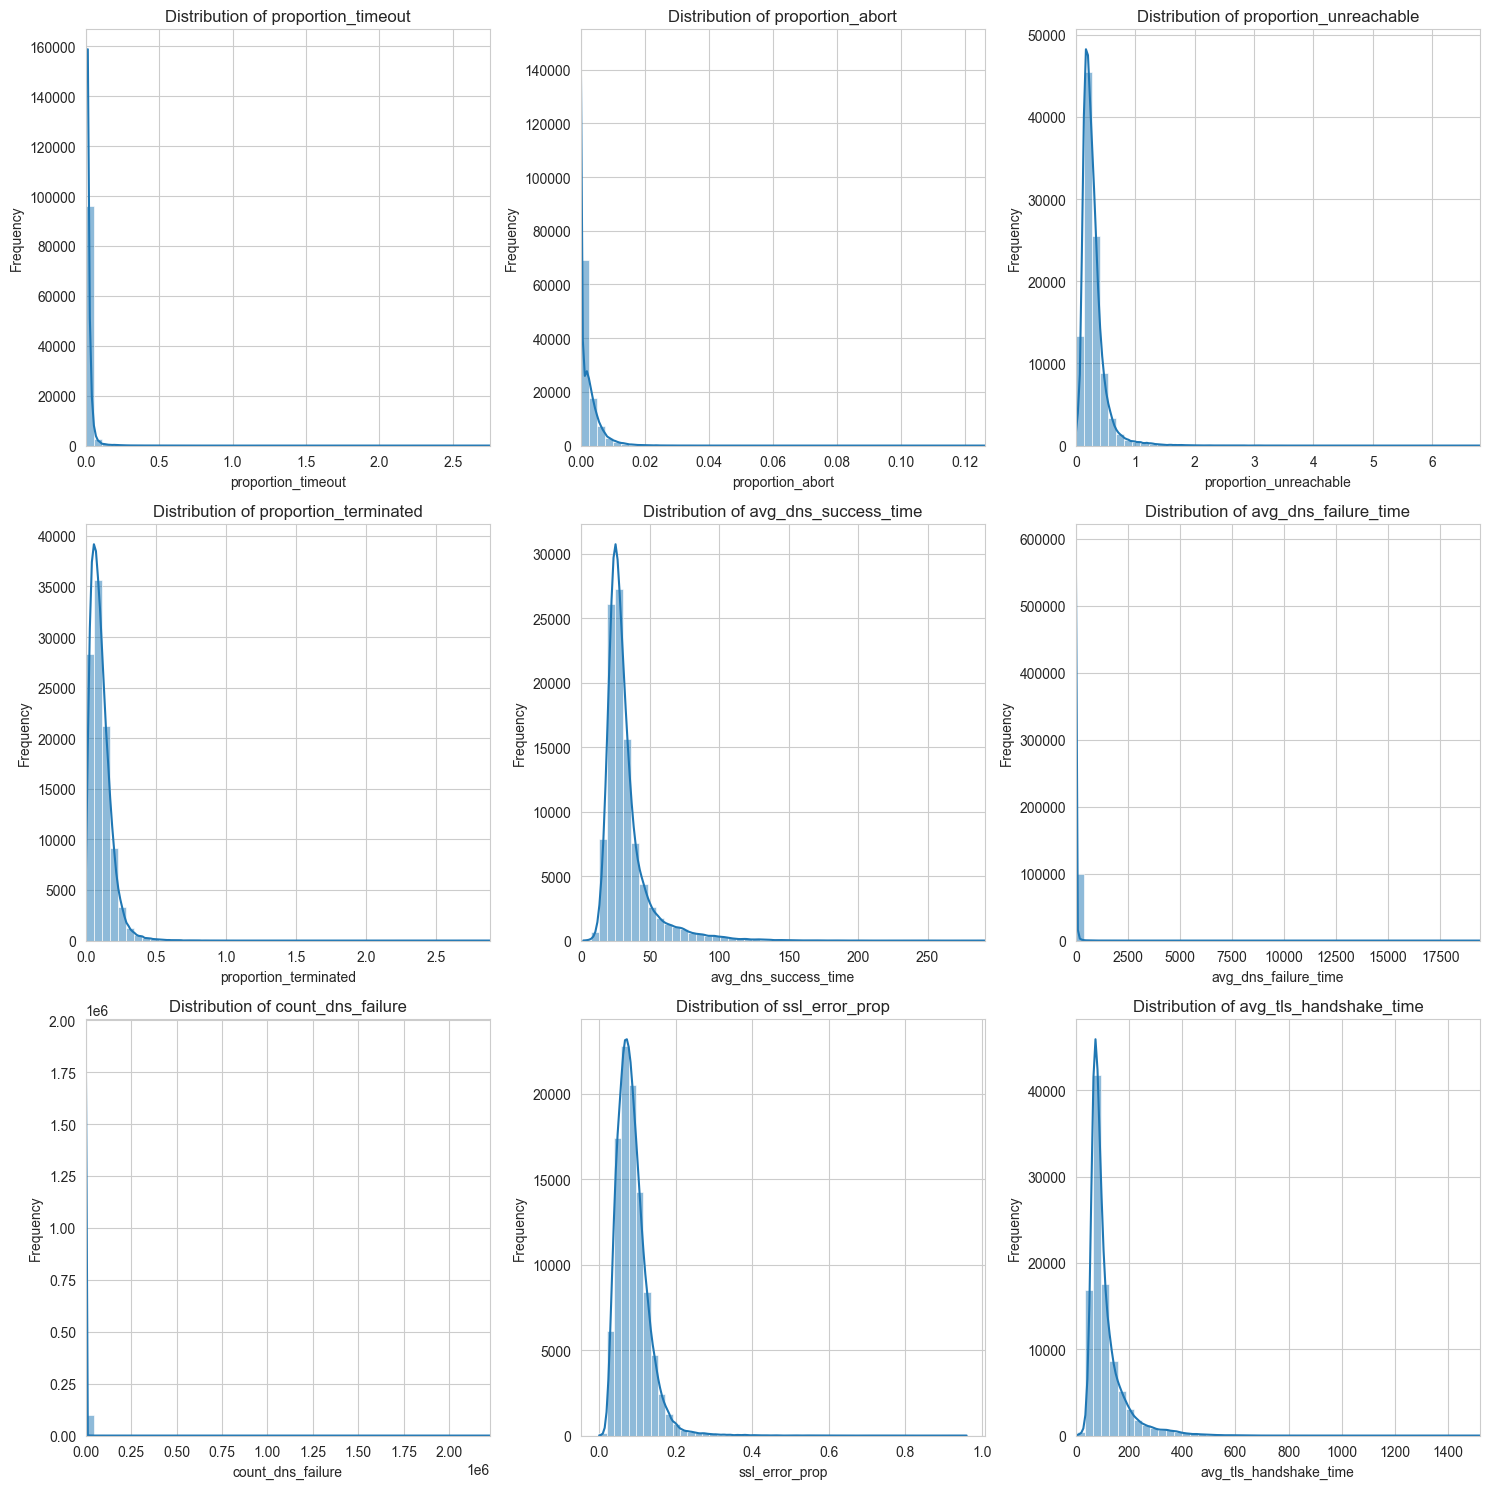

In [15]:
sns.set_style("whitegrid")

selected_columns = [
    'proportion_timeout', 'proportion_abort', 'proportion_unreachable',
    'proportion_terminated', 'avg_dns_success_time', 'avg_dns_failure_time',
    'count_dns_failure', 'ssl_error_prop', 'avg_tls_handshake_time'
]

plt.figure(figsize=(15, 15))
for i, col in enumerate(selected_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    if 'proportion' in col:
        plt.xlim(0, df[col].max()) 
    elif 'avg' in col:
        plt.xlim(0, df[col].max())
    elif 'count' in col:
        plt.xlim(0, df[col].max()) 

plt.tight_layout()
plt.show()

**Description**

The histogram above demonstrates the ditribution of the continuous features present in the dataset. Here we can observe that most of the proportion values lie between 0 and 1 and they have some values higher than 1 which can possibly be outliers. However, avg_tls_handshake_time, avg_dns_success_time and avg_dns_failure_time have much higher values present the reason behind this is that they are recorded in milliseconds and could be tranformed, if required.

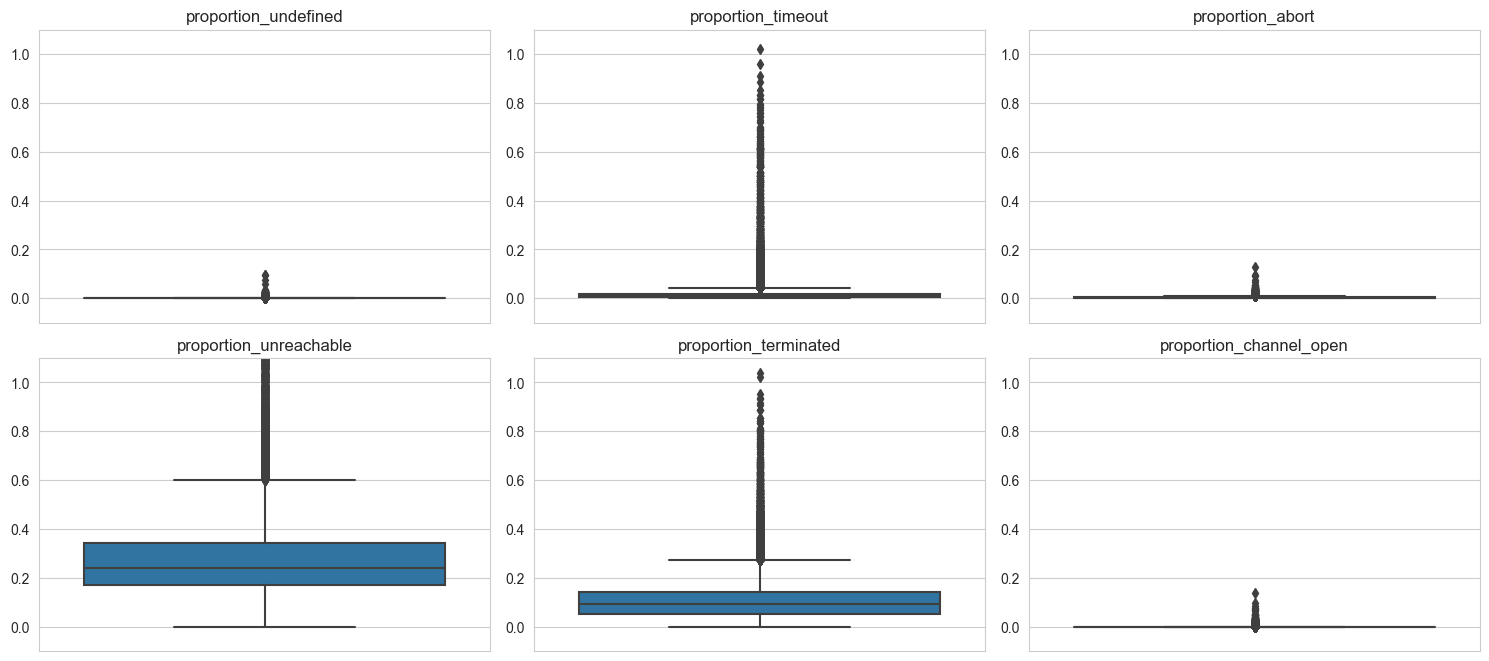

In [16]:
proportion_features = [col for col in df.columns if "proportion" in col]

plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

for i, feature in enumerate(proportion_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[feature])
    plt.ylim(-0.1, 1.1) 
    plt.title(feature)
    plt.ylabel("")

plt.tight_layout()
plt.show()

**Description**

The boxplots above visualizes the spread of data for proportion of the undefined, timeout, abort, unreachable, terminated, channel_open features respectively. They are necessary to understand our target feature as they're the set of features that captures the outcomes of the telemetry signals captured from the host machines. Here, we can observe that proportion_unreachable has the highest spread of values and also aligns with our target feature requirement as it captures the failure of upload of the telemetary signals indicating the possible outage.

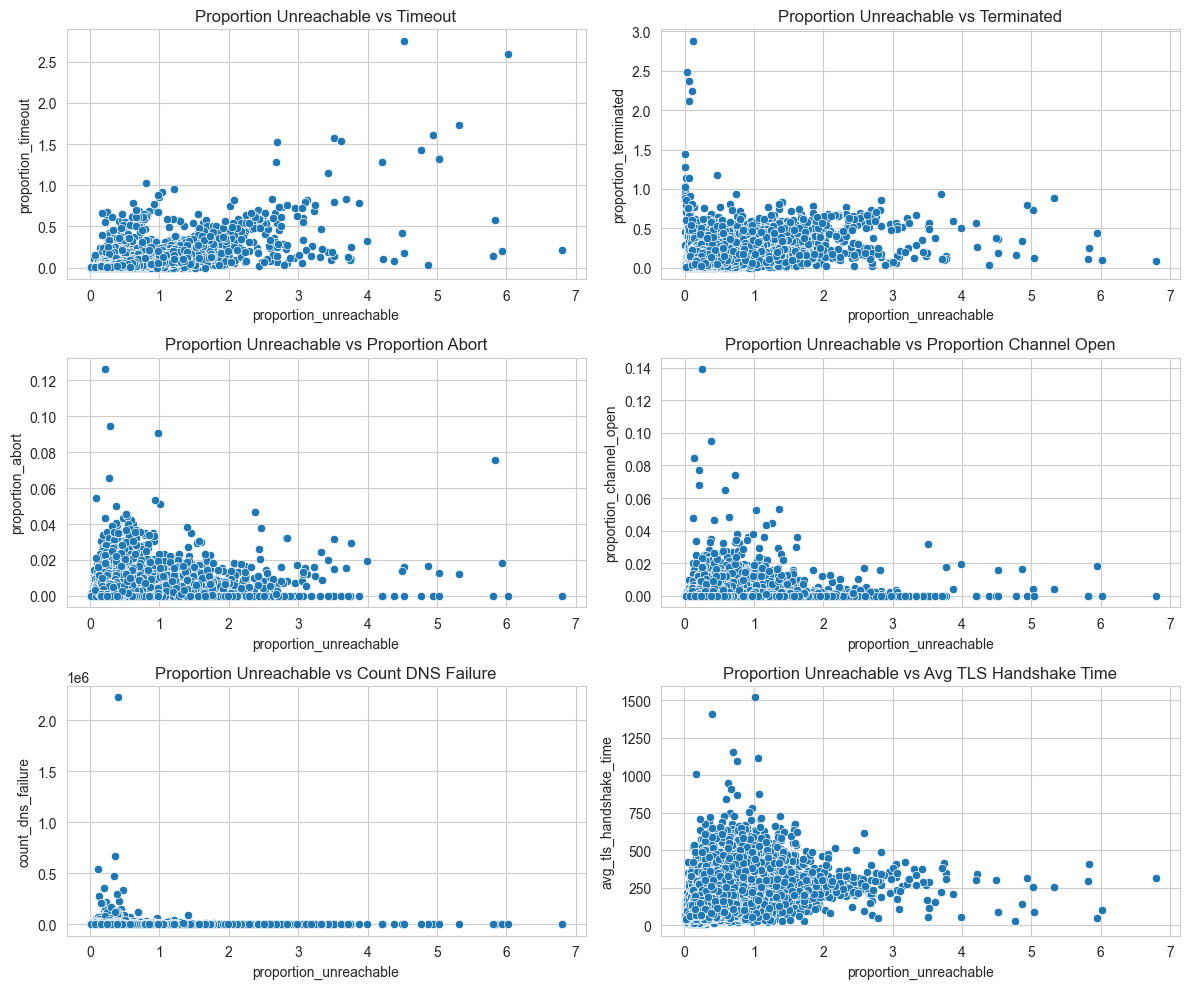

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

sns.scatterplot(data=df, x='proportion_unreachable', y='proportion_timeout', ax=axes[0, 0])
axes[0, 0].set_title('Proportion Unreachable vs Timeout')

sns.scatterplot(data=df, x='proportion_unreachable', y='proportion_terminated', ax=axes[0, 1])
axes[0, 1].set_title('Proportion Unreachable vs Terminated')


sns.scatterplot(data=df, x='proportion_unreachable', y='proportion_abort', ax=axes[1, 0])
axes[1, 0].set_title('Proportion Unreachable vs Proportion Abort')

sns.scatterplot(data=df, x='proportion_unreachable', y='proportion_channel_open', ax=axes[1, 1])
axes[1, 1].set_title('Proportion Unreachable vs Proportion Channel Open')

sns.scatterplot(data=df, x='proportion_unreachable', y='count_dns_failure', ax=axes[2,0])
axes[2,0].set_title('Proportion Unreachable vs Count DNS Failure')

sns.scatterplot(data=df, x='proportion_unreachable', y='avg_tls_handshake_time', ax=axes[2,1])
axes[2,1].set_title('Proportion Unreachable vs Avg TLS Handshake Time')

plt.tight_layout()
plt.show()

**Description**

The scatterplot above demonstrates the spread of the continuous features with respect to proportion_unreachable which is our target feature, this is to understand the correlation and the density of the values lying amongst the features.

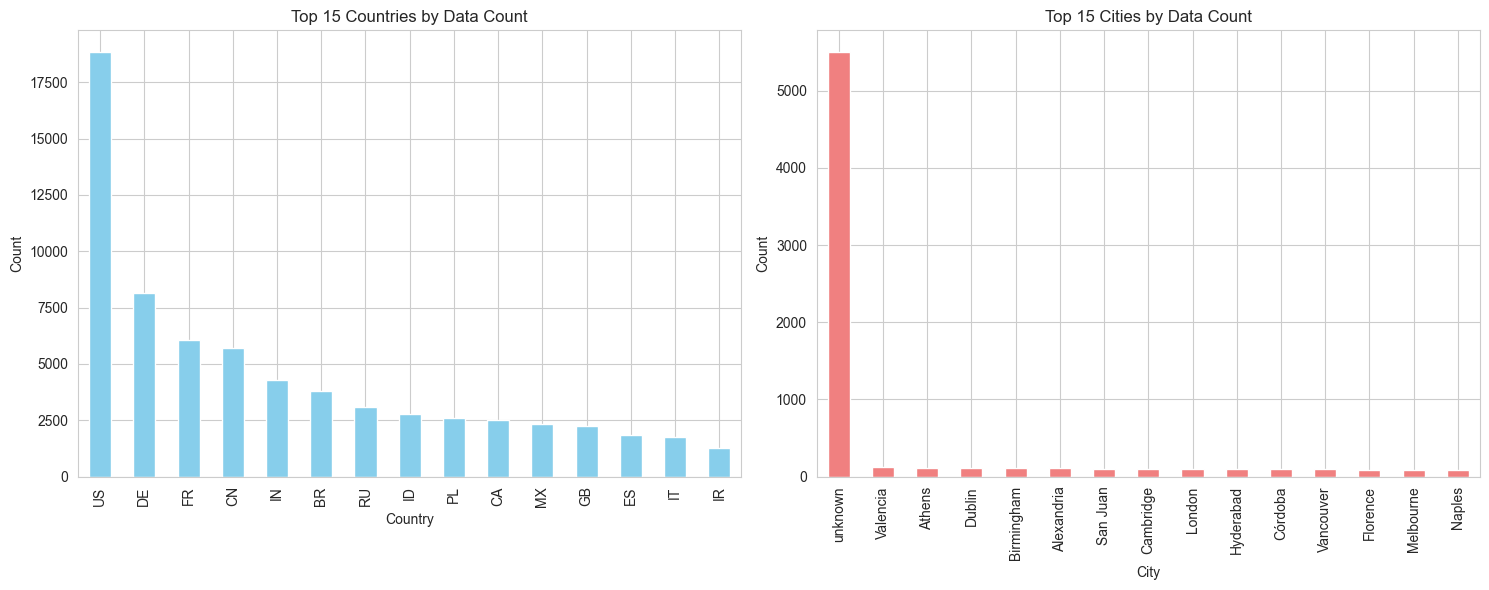

In [18]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
df['country'].value_counts().head(15).plot(kind='bar', color='skyblue')
plt.title('Top 15 Countries by Data Count')
plt.xlabel('Country')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['city'].value_counts().head(15).plot(kind='bar', color='lightcoral')
plt.title('Top 15 Cities by Data Count')
plt.xlabel('City')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

**Description**

The barplots above are used to demonstrate the top 15 countries and cities with highest data counts. It's quite significant that the most of the data is captures from United States followed by Germany, France and China. It's important to note that the cities have highest count for unknown as the cities with population less than 15,000 are labelled as unknows as originally mentioned by the data owners. 

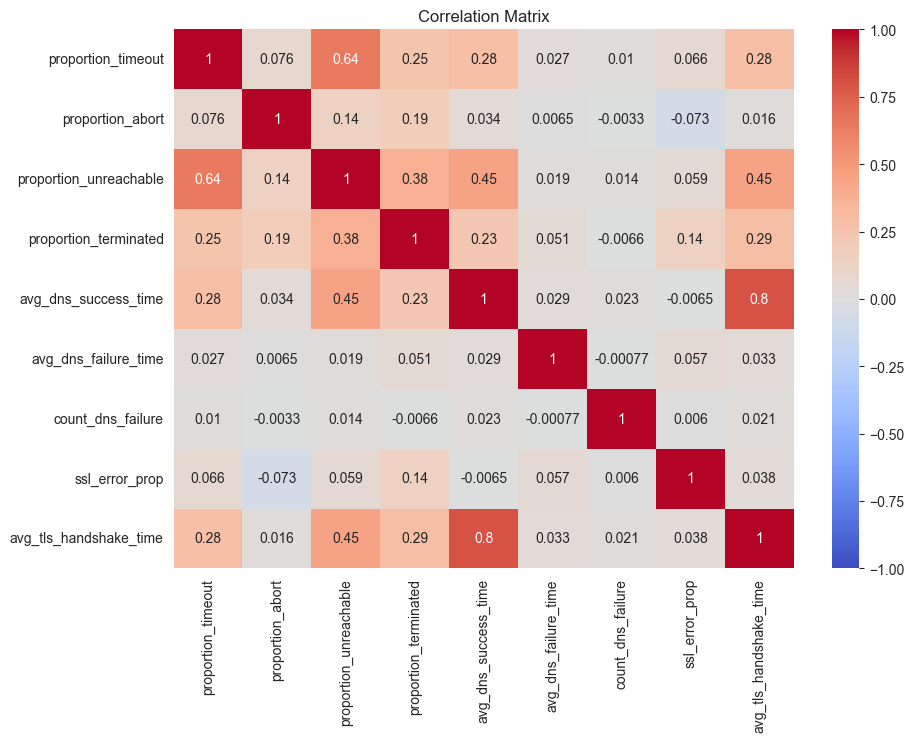

In [19]:
selected_numeric_features = [
    'proportion_timeout', 'proportion_abort', 'proportion_unreachable',
    'proportion_terminated', 'avg_dns_success_time', 'avg_dns_failure_time',
    'count_dns_failure', 'ssl_error_prop', 'avg_tls_handshake_time'
]


correlation_matrix = df[selected_numeric_features].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

**Description**

The heatmap above is used to understand the correlation between continuous features in the dataset. We can see that most of the features have positive correlation. However there are some features which have little negative correlation between them.

## 6. Data Cleaning & Transformation

### Handling country with null values

In [20]:
df_null_country = df[df['country'].isnull()]

In [21]:
df_null_country['city'].unique()

array(['Windhoek', 'unknown'], dtype=object)

In [22]:
city_windhoek_count = df_null_country['city'].value_counts()['Windhoek']
city_unknown_count =  df_null_country['city'].value_counts()['unknown']

total = (city_windhoek_count + city_unknown_count)

print('Windhoek count = {} and unknown count = {}'.format(city_windhoek_count, city_unknown_count))

Windhoek count = 51 and unknown count = 4


In [23]:
df.loc[df["city"] == "Windhoek", "country"] = 'NA'
df_null_country.loc[df_null_country["city"] == "Windhoek", "country"] = 'NA'

**Description**

Assigning the `country` value 'NA' i.e., Namibia where `city` is Windhoek.

In [24]:
df.isnull().sum()

country                    4
city                       0
datetime                   0
proportion_undefined       0
proportion_timeout         0
proportion_abort           0
proportion_unreachable     0
proportion_terminated      0
proportion_channel_open    0
avg_dns_success_time       0
missing_dns_success        0
avg_dns_failure_time       0
missing_dns_failure        0
count_dns_failure          2
ssl_error_prop             0
avg_tls_handshake_time     6
dtype: int64

In [25]:
df_null_country[df_null_country['country'].isnull()]

,country,city,datetime,proportion_undefined,proportion_timeout,proportion_abort,proportion_unreachable,proportion_terminated,proportion_channel_open,avg_dns_success_time,missing_dns_success,avg_dns_failure_time,missing_dns_failure,count_dns_failure,ssl_error_prop,avg_tls_handshake_time
26361,NaN,unknown,2023-04-05 06:00:00+00:00,0.000000,0.053097,0.000000,0.451327,0.008850,0.0,82.510774,0.0,17.581549,0.0,2083.666667,0.032609,444.273220
41975,NaN,unknown,2023-03-07 20:00:00+00:00,0.000000,0.047009,0.000000,0.653846,0.098291,0.0,59.742156,0.0,40.199173,0.0,368.438298,0.074713,314.610502
78294,NaN,unknown,2023-07-18 07:00:00+00:00,0.000000,0.029126,0.000000,0.417476,0.126214,0.0,69.842825,0.0,28.919879,0.0,225.678322,0.073770,343.967138
94393,NaN,unknown,2023-05-31 06:00:00+00:00,0.007299,0.036496,0.007299,0.357664,0.021898,0.0,60.225728,0.0,23.104651,0.0,206.733766,0.127660,404.031666


In [26]:
df.dropna(subset=['country'], inplace=True)

**Description**

Dropping all the remainder countries having null values as city is also unknown and the data count is significantly small.

In [27]:
df.isnull().sum()

country                    0
city                       0
datetime                   0
proportion_undefined       0
proportion_timeout         0
proportion_abort           0
proportion_unreachable     0
proportion_terminated      0
proportion_channel_open    0
avg_dns_success_time       0
missing_dns_success        0
avg_dns_failure_time       0
missing_dns_failure        0
count_dns_failure          2
ssl_error_prop             0
avg_tls_handshake_time     6
dtype: int64

### Handling all the null values

In [28]:
df = df.dropna()

**Description**

Dropping all the null values as the data count for null values is quite small.


In [29]:
df.isnull().sum()

country                    0
city                       0
datetime                   0
proportion_undefined       0
proportion_timeout         0
proportion_abort           0
proportion_unreachable     0
proportion_terminated      0
proportion_channel_open    0
avg_dns_success_time       0
missing_dns_success        0
avg_dns_failure_time       0
missing_dns_failure        0
count_dns_failure          0
ssl_error_prop             0
avg_tls_handshake_time     0
dtype: int64

### Handling city with unknown values

In [30]:
city_unknown_count =  df['city'].value_counts()['unknown']

city_unknown_count

5499

In [31]:
df_city_unknown = df[df['city'] == 'unknown']
df_city_unknown

,country,city,datetime,proportion_undefined,proportion_timeout,proportion_abort,proportion_unreachable,proportion_terminated,proportion_channel_open,avg_dns_success_time,missing_dns_success,avg_dns_failure_time,missing_dns_failure,count_dns_failure,ssl_error_prop,avg_tls_handshake_time
10,HK,unknown,2023-02-17 03:00:00+00:00,0.000218,0.008796,0.003126,0.147561,0.128662,0.000073,18.788116,0.000000,10.238746,0.000000,295.627839,0.074664,84.555695
11,SG,unknown,2023-01-25 15:00:00+00:00,0.000441,0.017181,0.002863,0.229515,0.092511,0.000661,22.106430,0.000000,12.752962,0.000000,420.472404,0.077952,79.517591
20,TR,unknown,2023-07-24 10:00:00+00:00,0.000000,0.006722,0.003102,0.292658,0.219752,0.001551,29.293957,0.000000,18.158585,0.000000,239.892795,0.089658,128.060835
32,CO,unknown,2023-08-14 00:00:00+00:00,0.000879,0.003515,0.000879,0.127417,0.079965,0.000000,48.343223,0.000000,7.192585,0.001866,1607.253394,0.106965,164.052343
47,DZ,unknown,2023-07-07 03:00:00+00:00,0.001805,0.012635,0.001805,0.272563,0.066787,0.000000,74.515760,0.000000,14.536894,0.000000,278.233380,0.094819,186.574527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99876,NO,unknown,2023-04-21 05:00:00+00:00,0.000244,0.010483,0.000000,0.250366,0.012677,0.000000,18.444357,0.000000,2.722794,0.000000,775.631877,0.048447,56.206521
99904,RU,unknown,2023-02-22 21:00:00+00:00,0.000000,0.001113,0.000043,0.017587,0.004793,0.000043,13.342282,0.000025,19.391710,0.000000,396.319271,0.121056,39.499160
99965,CU,unknown,2023-01-26 03:00:00+00:00,0.003521,0.116197,0.007042,0.785211,0.172535,0.003521,94.417320,0.000000,30.115587,0.000000,363.407555,0.124594,452.534639
99979,BJ,unknown,2023-02-10 07:00:00+00:00,0.000000,0.019737,0.000000,0.381579,0.039474,0.000000,83.895231,0.000000,7.758119,0.000000,844.812203,0.065335,257.463150


## 7. Feature Engineering

### Define time slots

In [32]:
# Convert 'datetime' to 'hour'
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour

# Define time slots
def get_detailed_time_slot(hour):
    if 0 <= hour < 6:
        return 'Late Night'
    elif 6 <= hour < 9:
        return 'Early Morning'
    elif 9 <= hour < 12:
        return 'Late Morning'
    elif 12 <= hour < 15:
        return 'Early Afternoon'
    elif 15 <= hour < 18:
        return 'Late Afternoon'
    elif 18 <= hour < 21:
        return 'Early Evening'
    else:
        return 'Night'

df['time_slot'] = df['hour'].apply(get_detailed_time_slot)

### Class Labeling (Data discretization) using composite score

In [33]:
# Example features that might contribute to an internet quality score
features = ['proportion_timeout', 'proportion_unreachable', 'proportion_terminated', 
            'avg_dns_failure_time', 'count_dns_failure']

# Create a composite score as a simple sum of standardized features
df['composite_score'] = df[features].apply(lambda x: (x - x.mean()) / x.std()).sum(axis=1)

# Calculate the quantiles on this composite score
quantiles = df['composite_score'].quantile([0.25, 0.5, 0.75])

# Define the labeling function with the correct quartile values
def label_quality(score, quantiles):
    if score <= quantiles[0.25]:
        return 'good'
    elif score <= quantiles[0.50]:
        return 'moderate'
    elif score <= quantiles[0.75]:
        return 'bad'
    else:
        return 'worse'

# Apply the labeling function to each row in your dataframe
df['quality_label'] = df['composite_score'].apply(label_quality, quantiles=quantiles)

# Map the categorical labels to integers
label_map = {'good': 0, 'moderate': 1, 'bad': 2, 'worse': 3}
df['quality_label_encoded'] = df['quality_label'].map(label_map)


In [34]:
pd.set_option('display.max_columns', None)

In [35]:
df.head()

,country,city,datetime,proportion_undefined,proportion_timeout,proportion_abort,proportion_unreachable,proportion_terminated,proportion_channel_open,avg_dns_success_time,missing_dns_success,avg_dns_failure_time,missing_dns_failure,count_dns_failure,ssl_error_prop,avg_tls_handshake_time,hour,time_slot,composite_score,quality_label,quality_label_encoded
0,FR,Romans-sur-Isère,2023-02-20 09:00:00+00:00,0.000000,0.003656,0.003656,0.124314,0.076782,0.000000,31.169516,0.000000,14.564475,0.0,46.423855,0.040471,91.977353,9,Late Morning,-1.635402,good,0
1,US,Dublin,2023-08-28 04:00:00+00:00,0.000000,0.007201,0.000000,0.058506,0.009001,0.000000,30.415173,0.000000,19.549192,0.0,352.765659,0.126770,75.952639,4,Late Night,-2.662244,good,0
2,IN,Chennai,2023-05-14 19:00:00+00:00,0.000000,0.005670,0.000000,0.093127,0.017526,0.000344,23.443062,0.000078,9.709975,0.0,823.013169,0.084169,47.767434,19,Early Evening,-2.435160,good,0
3,CH,Lugano,2023-05-02 10:00:00+00:00,0.000000,0.004975,0.002488,0.194030,0.059701,0.000000,17.499015,0.000000,9.997338,0.0,77.104019,0.052542,70.791734,10,Late Morning,-1.523231,good,0
4,US,San Jose,2023-04-14 17:00:00+00:00,0.000937,0.026546,0.001249,0.387570,0.053092,0.000000,37.155666,0.000000,7.158672,0.0,8786.161484,0.082357,90.034052,17,Late Afternoon,0.874032,worse,3


### Checking feature importance using RFE

In [36]:
X = df.drop(['quality_label', 'quality_label_encoded', 'datetime','time_slot', 'country', 'city'], axis=1)
y = df['quality_label_encoded']

# Create the RFE object and rank each pixel
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
rfe.fit(X, y)

# RFE ranking
ranking_rfe = rfe.ranking_

# To map these rankings back to column names:
rfe_dict = dict(zip(X.columns, ranking_rfe))
sorted_rfe = sorted(rfe_dict.items(), key=lambda item: item[1])

# sorted_rfe now contains features and their RFE ranking, sorted from most to least important

In [37]:
print(sorted_rfe)

[('proportion_timeout', 1), ('proportion_unreachable', 1), ('proportion_terminated', 1), ('avg_dns_success_time', 1), ('avg_dns_failure_time', 1), ('count_dns_failure', 1), ('ssl_error_prop', 1), ('avg_tls_handshake_time', 1), ('hour', 1), ('composite_score', 1), ('proportion_abort', 2), ('proportion_channel_open', 3), ('proportion_undefined', 4), ('missing_dns_failure', 5), ('missing_dns_success', 6)]


### Encoding the categorical columns

In [38]:
# Label encode 'country' and 'city'
label_encoder_country = LabelEncoder()
label_encoder_city = LabelEncoder()
ordinal_encoder_time_slot = OrdinalEncoder()

# Assuming 'data' is your DataFrame
df['country_encoded'] = label_encoder_country.fit_transform(df['country'])
df['city_encoded'] = label_encoder_city.fit_transform(df['city'])

# Assuming 'time_slot' is a categorical variable that you want to encode ordinally
df['time_slot_encoded'] = ordinal_encoder_time_slot.fit_transform(df[['time_slot']])

# For 'composite_score', first, we need to convert it into quartile bins
# Then we'll use ordinal encoding on these bins
#data['quality_label_encoded'] = pd.qcut(data['quality_label'], q=4, labels=False)

# Drop the original columns that have been encoded
df.drop(['country', 'city', 'time_slot', 'quality_label'], axis=1, inplace=True)

## 8. Splitting the dataset into test, train and validate  sets

In [39]:
# Features are separated: numerical features that need scaling and categorical encoded features that don't
numerical_features = ['proportion_timeout', 'proportion_unreachable', 'proportion_terminated', 
                      'avg_dns_success_time', 'avg_dns_failure_time', 'count_dns_failure', 'ssl_error_prop']
categorical_features = ['country_encoded', 'city_encoded', 'time_slot_encoded']
X_numerical = df[numerical_features]
X_categorical = df[categorical_features]

# Target variable
y = df['quality_label_encoded']

# Split the data into train+validate and test sets (90-10 split)
X_temp_num, X_test_num, y_temp, y_test = train_test_split(X_numerical, y, test_size=0.1, stratify=y, random_state=42, shuffle=True)
X_temp_cat, X_test_cat = train_test_split(X_categorical, test_size=0.1, random_state=42, shuffle=True)

# Further split the train+validate into train and validate sets (89-11 split, approximates to 80-10 of original)
X_train_num, X_validate_num, y_train, y_validate = train_test_split(X_temp_num, y_temp, test_size=1/9, stratify=y_temp, random_state=42, shuffle=True)
X_train_cat, X_validate_cat = train_test_split(X_temp_cat, test_size=1/9, random_state=42, shuffle=True)

In [40]:
X_train_num.shape

(79991, 7)

### Initialize the StandardScaler for numerical features

In [41]:
scaler = StandardScaler()

# Fit the scaler on the numerical part of the training data and transform
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_validate_num_scaled = scaler.transform(X_validate_num)
X_test_num_scaled = scaler.transform(X_test_num)

### Combining scaled continous and categorical features

In [42]:
X_train = np.concatenate((X_train_num_scaled, X_train_cat.values), axis=1)
X_validate = np.concatenate((X_validate_num_scaled, X_validate_cat.values), axis=1)
X_test = np.concatenate((X_test_num_scaled, X_test_cat.values), axis=1)

In [43]:
print('Continous features scaled shape', X_train_num_scaled.shape)
print('Categorical features shape', X_train_cat.shape)
print('X train shape', X_train.shape)

Continous features scaled shape (79991, 7)
Categorical features shape (79991, 3)
X train shape (79991, 10)


### Checking the count of each class in the target feature

In [44]:
# Check class distribution in the target feature
class_counts = y_train.value_counts()
print(class_counts)

# Decide to use SMOTE based on class distribution
# Generally, if any class is less than 10-20% of the majority class, SMOTE might be useful

quality_label_encoded
3    19998
0    19998
1    19998
2    19997
Name: count, dtype: int64


### Applying SMOTE to the training set if the classes are imbalanced

In [45]:
# Initialize SMOTE and resample the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## 9. Modeling using Random Forest

In [46]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

## 10. Model Evaluation

###  Plotting accuracies for Decision Trees with varying depths:

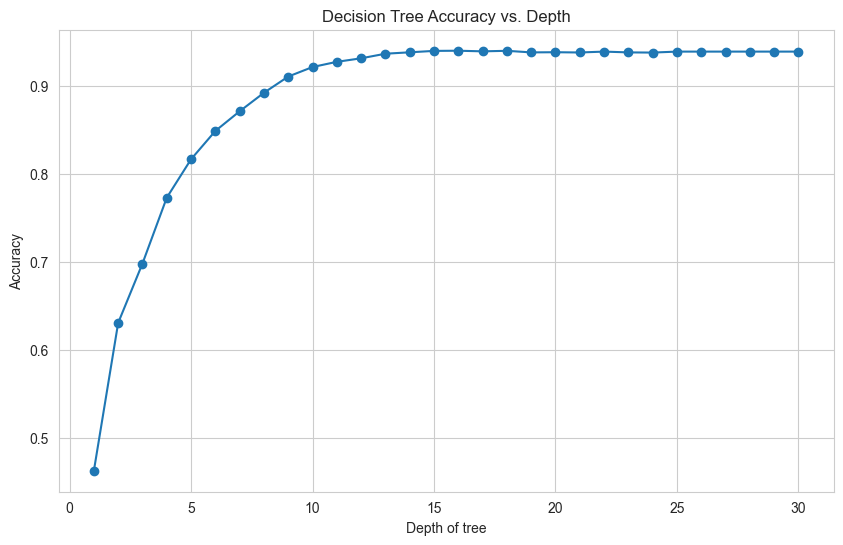

In [47]:
# Initialize variables
depths = range(1, 31)  # Tree depths from 1 to 30
accuracies = []

# Loop over various depths
for depth in depths:
    dt_classifier = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_classifier.fit(X_train_smote, y_train_smote)
    y_pred = dt_classifier.predict(X_validate)
    accuracies.append(accuracy_score(y_validate, y_pred))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(depths, accuracies, marker='o')
plt.title('Decision Tree Accuracy vs. Depth')
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

### Confusion Matrix

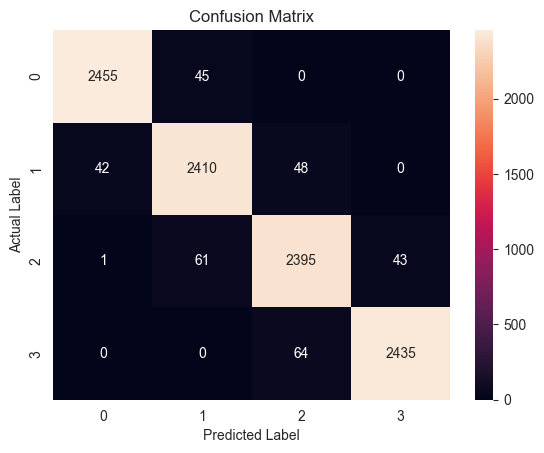

In [48]:
y_pred_validate = rf_classifier.predict(X_validate)

# Compute the confusion matrix
cm = confusion_matrix(y_validate, y_pred_validate)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Classification Report:

In [49]:

# Generate a classification report
report = classification_report(y_validate, y_pred_validate)
print(report)


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2500
           1       0.96      0.96      0.96      2500
           2       0.96      0.96      0.96      2500
           3       0.98      0.97      0.98      2499

    accuracy                           0.97      9999
   macro avg       0.97      0.97      0.97      9999
weighted avg       0.97      0.97      0.97      9999



### Saving model

In [50]:
# Save the model to a file
joblib.dump(rf_classifier, 'random_forest_model.pkl')


['random_forest_model.pkl']

### Testing model

In [51]:
y_pred_test = rf_classifier.predict(X_test)

# Evaluate the predictions using accuracy or any other suitable metric
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9660966096609661


### Loading the Model:

In [52]:
# Load the model from the file
loaded_rf_classifier = joblib.load('random_forest_model.pkl')

### Testing model by predicting the internet outage

In [53]:
def predict_outage(country_input, city_input, time_slot_input):
    try:
        # Encode the country and city inputs
        country_encoded = label_encoder_country.transform([country_input])[0]
        city_encoded = label_encoder_city.transform([city_input])[0]
    except ValueError:
        # Handle the error if the input country or city is not recognized
        return "Country or City not recognized"

    # Convert time_slot_input to hour and then to the corresponding time slot category
    time_slot_to_hour = {'Late Night': 0, 'Early Morning': 6, 'Late Morning': 9, 
                         'Early Afternoon': 12, 'Late Afternoon': 15, 
                         'Early Evening': 18, 'Night': 21}
    hour = time_slot_to_hour.get(time_slot_input, -1)  # Default to -1 if time slot is not recognized

    # Check if the time slot is valid
    if hour == -1:
        return "Time slot not recognized"

    time_slot_category = get_detailed_time_slot(hour)

    # Assuming you have an encoder for time_slot_category
    try:
        time_slot_encoded = ordinal_encoder_time_slot.transform([[time_slot_category]])[0][0]
    except ValueError:
        return "Time slot category not recognized"

        # Default or average values for the remaining features
    default_values = {
        'proportion_timeout': -0.493079246734771,  # replace with the average or typical value if known
        'proportion_unreachable': -0.34482143954133,
        'proportion_terminated': 0.231413618470646,
        'avg_dns_success_time': -0.690814659476422,
        'avg_dns_failure_time': -0.136988650019605,
        'count_dns_failure': -0.0816727213548191,
        'ssl_error_prop': -0.364139002049091
    }
    
    # Create a DataFrame for all input features
    input_features = pd.DataFrame({
        'country_encoded': [country_encoded],
        'city_encoded': [city_encoded],
        'time_slot_encoded': [time_slot_encoded],
        **default_values
    })



    # Make a prediction using the Random Forest classifier
    numeric_prediction = loaded_rf_classifier.predict(input_features)[0]

    # Reverse mapping from integer to string labels
    reverse_label_map = {0: 'good', 1: 'moderate', 2: 'bad', 3: 'worse'}
    string_prediction = reverse_label_map.get(numeric_prediction, "Unknown")

    return string_prediction
# Example usage
print(predict_outage('GB', 'London', 'Late Afternoon'))


worse
